In [1]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping  
import glob as gb 
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

2024-05-17 09:23:18.585637: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 09:23:19.666398: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
IMG_SIZE = 224
SEED = 1000
BATCH_SIZE = 16
TRAIN_DIR = '/mnt/g/food-101.zip/Training_data'
TEST_DIR = '/mnt/g/food-101.zip/Test_data'

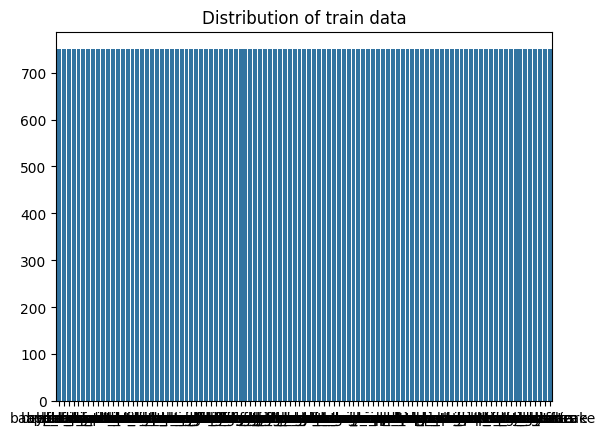

75750


In [3]:
categories = []
class_count=[]
train_exm = 0
for f in os.listdir(TRAIN_DIR):
    files = gb.glob(pathname=str(TRAIN_DIR + '/' + f + '/*.jpg'))
    categories.append(f)
    class_count.append(len(files))
    train_exm += len(files)

sns.barplot(x=categories, y=class_count).set_title("Distribution of train data")

plt.show()
print(train_exm)

In [4]:
# def preprocess_input(img):
#     img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
#     img = tf.keras.applications.efficientnet.preprocess_input(img)
#     return img

train_gen = ImageDataGenerator(
   rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.1,
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
    #dtype=tf.float32

)

test_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
    #dtype=tf.float32
)

In [5]:
train_batch = train_gen.flow_from_directory(
    directory = TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset = 'training',
    seed=SEED
)

valid_batch = train_gen.flow_from_directory(
    directory = TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset = 'validation',
    seed=SEED
)

test_batch = test_gen.flow_from_directory(
    directory = TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    seed = SEED
)

Found 60600 images belonging to 101 classes.
Found 15150 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


In [7]:
img_shape = (IMG_SIZE, IMG_SIZE) +(3,)
base_model = tf.keras.applications.EfficientNetB5(input_shape=img_shape, include_top=False, weights='imagenet')
base_model.summary()


115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step


Model: "efficientnetb5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      1,152 │ block1a_se_excit

 Total params: 28,513,527 (108.77 MB)

 Trainable params: 28,340,784 (108.11 MB)

 Non-trainable params: 172,743 (674.78 KB)

In [8]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Corrected dropout without activation
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(101, activation='softmax')(x)
model = tf.keras.Model(inputs, output)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb5 (Functional)     │ (None, 7, 7, 2048)     │    28,513,527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 101)            │        13,029 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,739,868 (113.45 MB)

 Trainable params: 29,567,125 (112.79 MB)

 Non-trainable params: 172,743 (674.78 KB)

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
loss=tf.keras.losses.sparse_categorical_crossentropy,
metrics=['accuracy'])  

In [10]:
h = model.fit(train_batch, 
    steps_per_epoch=642,
validation_data=valid_batch,
validation_steps=158,
 epochs=50, 
 callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],
 verbose=1)

Epoch 1/50


/home/tan/anaconda3/envs/myenv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1715916428.866976    1950 service.cc:145] XLA service 0x7f298c004160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715916428.867031    1950 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-05-17 09:27:11.137728: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-17 09:27:18.118900: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900
2024-0

417/642 ━━━━━━━━━━━━━━━━━━━━ 55s 249ms/step - accuracy: 0.0118 - loss: 4.6155

I0000 00:00:1715916792.847549    1950 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 44 bytes spill stores, 44 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_3', 172 bytes spill stores, 172 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion', 300 bytes spill stores, 300 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_725', 44 bytes spill stores, 44 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_723', 44 bytes spill stores, 44 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_9', 36 bytes spill stores, 36 bytes spill loads



642/642 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.0149 - loss: 4.6051

I0000 00:00:1715916857.781494    6410 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4807', 4 bytes spill stores, 4 bytes spill loads



642/642 ━━━━━━━━━━━━━━━━━━━━ 531s 527ms/step - accuracy: 0.0149 - loss: 4.6050 - val_accuracy: 0.1210 - val_loss: 4.2356
Epoch 2/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 202s 315ms/step - accuracy: 0.1102 - loss: 4.0974 - val_accuracy: 0.3350 - val_loss: 2.9620
Epoch 3/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 195s 304ms/step - accuracy: 0.2604 - loss: 3.2190 - val_accuracy: 0.4442 - val_loss: 2.3804
Epoch 4/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 199s 311ms/step - accuracy: 0.3394 - loss: 2.7999 - val_accuracy: 0.5119 - val_loss: 1.9951
Epoch 5/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 186s 290ms/step - accuracy: 0.4068 - loss: 2.4794 - val_accuracy: 0.5629 - val_loss: 1.7936
Epoch 6/50
578/642 ━━━━━━━━━━━━━━━━━━━━ 13s 215ms/step - accuracy: 0.4589 - loss: 2.2605

2024-05-17 09:50:07.793243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-17 09:50:07.794100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/tan/anaconda3/envs/myenv/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


642/642 ━━━━━━━━━━━━━━━━━━━━ 166s 258ms/step - accuracy: 0.4591 - loss: 2.2581 - val_accuracy: 0.5948 - val_loss: 1.7010
Epoch 7/50


2024-05-17 09:50:49.380155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-17 09:50:49.380506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


642/642 ━━━━━━━━━━━━━━━━━━━━ 207s 320ms/step - accuracy: 0.5143 - loss: 2.0169 - val_accuracy: 0.6226 - val_loss: 1.5591
Epoch 8/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 196s 306ms/step - accuracy: 0.5368 - loss: 1.9384 - val_accuracy: 0.6309 - val_loss: 1.4820
Epoch 9/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 189s 295ms/step - accuracy: 0.5520 - loss: 1.8347 - val_accuracy: 0.6226 - val_loss: 1.5288
Epoch 10/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 180s 280ms/step - accuracy: 0.5717 - loss: 1.7935 - val_accuracy: 0.6835 - val_loss: 1.3236
Epoch 11/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 172s 268ms/step - accuracy: 0.5972 - loss: 1.6279 - val_accuracy: 0.6685 - val_loss: 1.4404
Epoch 12/50
578/642 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - accuracy: 0.6145 - loss: 1.6000

2024-05-17 10:08:34.002910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-17 10:08:34.003656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


642/642 ━━━━━━━━━━━━━━━━━━━━ 147s 229ms/step - accuracy: 0.6144 - loss: 1.5990 - val_accuracy: 0.6841 - val_loss: 1.3555
Epoch 13/50


2024-05-17 10:09:00.766823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-17 10:09:00.767776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


642/642 ━━━━━━━━━━━━━━━━━━━━ 173s 267ms/step - accuracy: 0.6070 - loss: 1.5952 - val_accuracy: 0.6772 - val_loss: 1.3640
Epoch 14/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 170s 264ms/step - accuracy: 0.6218 - loss: 1.5356 - val_accuracy: 0.6946 - val_loss: 1.3062
Epoch 15/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 166s 258ms/step - accuracy: 0.6461 - loss: 1.4521 - val_accuracy: 0.7160 - val_loss: 1.2504
Epoch 16/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 163s 254ms/step - accuracy: 0.6607 - loss: 1.3918 - val_accuracy: 0.7057 - val_loss: 1.3005
Epoch 17/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 158s 246ms/step - accuracy: 0.6716 - loss: 1.3248 - val_accuracy: 0.7104 - val_loss: 1.2599
Epoch 18/50
578/642 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.6855 - loss: 1.2731

2024-05-17 10:24:42.308659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-17 10:24:42.309871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


642/642 ━━━━━━━━━━━━━━━━━━━━ 137s 214ms/step - accuracy: 0.6852 - loss: 1.2756 - val_accuracy: 0.7048 - val_loss: 1.3281
Epoch 19/50


2024-05-17 10:25:07.748982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-17 10:25:07.750262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


642/642 ━━━━━━━━━━━━━━━━━━━━ 165s 254ms/step - accuracy: 0.6819 - loss: 1.2973 - val_accuracy: 0.7160 - val_loss: 1.2354
Epoch 20/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 161s 251ms/step - accuracy: 0.7015 - loss: 1.2213 - val_accuracy: 0.6990 - val_loss: 1.3669
Epoch 21/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 159s 248ms/step - accuracy: 0.7159 - loss: 1.1859 - val_accuracy: 0.7124 - val_loss: 1.3143
Epoch 22/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 157s 245ms/step - accuracy: 0.7150 - loss: 1.1661 - val_accuracy: 0.7104 - val_loss: 1.3073
Epoch 23/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 154s 239ms/step - accuracy: 0.7192 - loss: 1.1501 - val_accuracy: 0.7243 - val_loss: 1.2563
Epoch 24/50
578/642 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step - accuracy: 0.7102 - loss: 1.1676

2024-05-17 10:40:11.925725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-17 10:40:11.927998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


642/642 ━━━━━━━━━━━━━━━━━━━━ 134s 208ms/step - accuracy: 0.7104 - loss: 1.1662 - val_accuracy: 0.7351 - val_loss: 1.1975
Epoch 25/50


2024-05-17 10:40:36.736007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-17 10:40:36.736303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


642/642 ━━━━━━━━━━━━━━━━━━━━ 160s 246ms/step - accuracy: 0.7215 - loss: 1.1273 - val_accuracy: 0.7389 - val_loss: 1.1659
Epoch 26/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 157s 244ms/step - accuracy: 0.7324 - loss: 1.0909 - val_accuracy: 0.7369 - val_loss: 1.2402
Epoch 27/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 156s 243ms/step - accuracy: 0.7351 - loss: 1.0717 - val_accuracy: 0.7282 - val_loss: 1.2740
Epoch 28/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 154s 240ms/step - accuracy: 0.7431 - loss: 1.0490 - val_accuracy: 0.7401 - val_loss: 1.2303
Epoch 29/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 151s 236ms/step - accuracy: 0.7520 - loss: 0.9872 - val_accuracy: 0.7259 - val_loss: 1.3645
Epoch 30/50
578/642 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - accuracy: 0.7482 - loss: 0.9932

2024-05-17 10:55:22.104586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-17 10:55:22.106149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


642/642 ━━━━━━━━━━━━━━━━━━━━ 132s 206ms/step - accuracy: 0.7484 - loss: 0.9937 - val_accuracy: 0.7319 - val_loss: 1.2683


2024-05-17 10:55:46.582567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-17 10:55:46.582969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


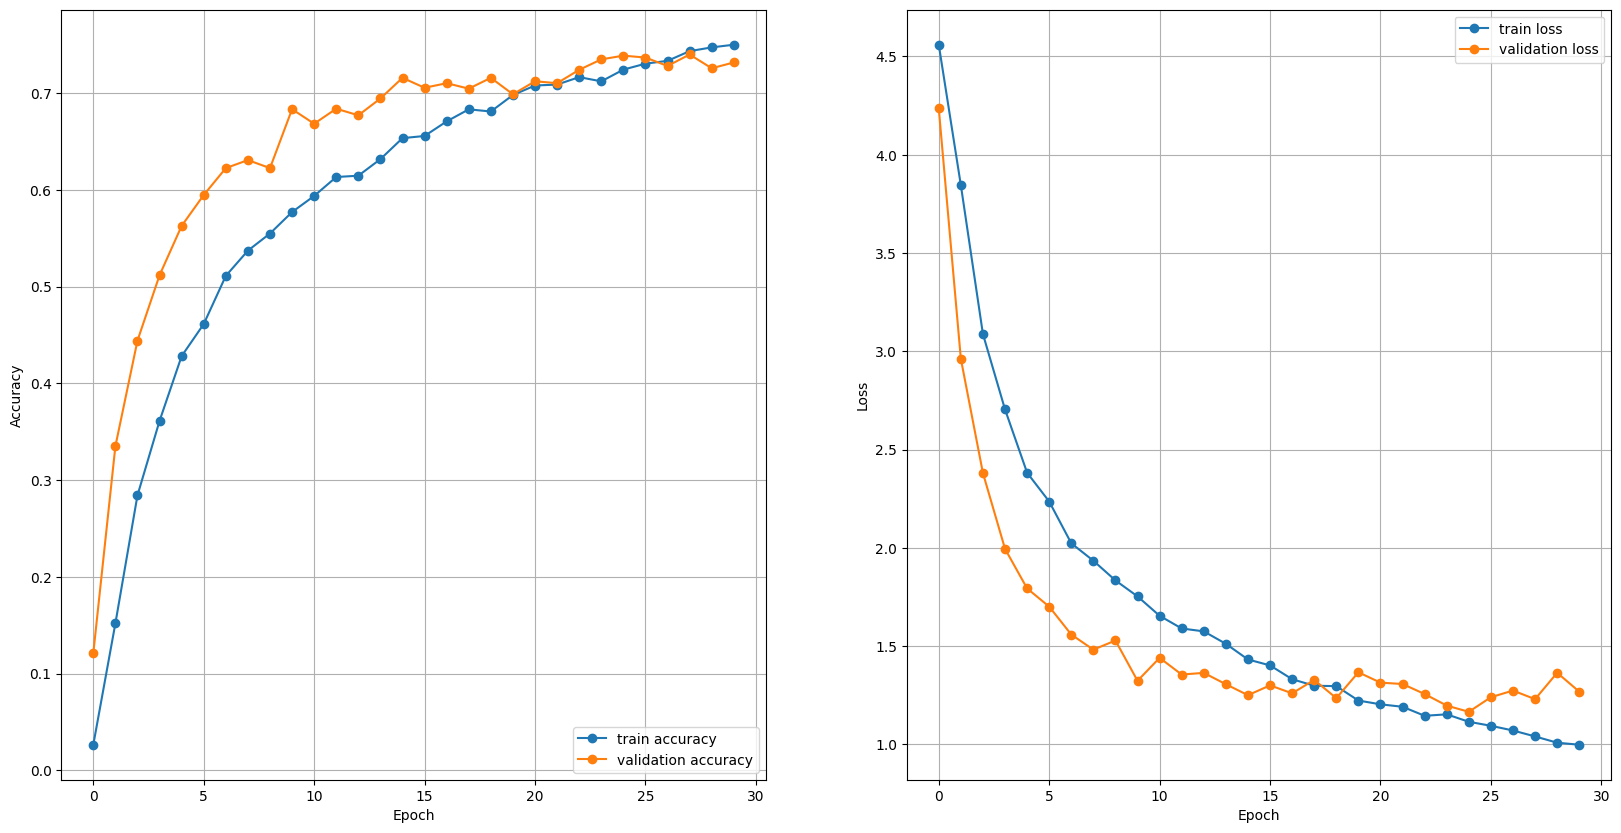

In [11]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train accuracy')
plt.plot(h.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')
plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train loss')
plt.plot(h.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()